In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [13]:
# 合成数据
def synthetic_data(w, b, num_examples):
    "生成y=Xw+b+噪音"
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
print("features: ", features[0], "\nlabels:", labels[0])

features:  tensor([2.1024, 0.8432]) 
labels: tensor([5.5355])


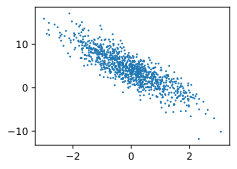

In [15]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5937, -0.8312],
        [-0.0536,  1.1065],
        [ 1.3715, -1.4755],
        [ 1.2584, -1.2518],
        [ 0.2241,  1.2124],
        [ 0.3466,  0.1900],
        [-1.4788, -1.4452],
        [ 0.7834, -0.3001],
        [-0.1103, -1.5257],
        [-0.1528, -0.2619]]) 
 tensor([[ 8.2008],
        [ 0.3370],
        [11.9411],
        [10.9743],
        [ 0.5542],
        [ 4.2548],
        [ 6.1562],
        [ 6.7913],
        [ 9.1462],
        [ 4.7886]])


In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [18]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [19]:
def squared_loss(y_hat, y):
    """均方损失"""
    # print(y_hat.shape, y.shape)
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
# 定义优化函数
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad /batch_size
            param.grad.zero_()

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # 因为l的形状是(batch_size, 1)，而不是一个标量，累加并以此计算参数的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.032206
epoch 2, loss 0.000115
epoch 3, loss 0.000052


In [22]:
print(f"w的估计误差：{true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差：{true_b -b}")

w的估计误差：tensor([ 0.0007, -0.0007], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0007], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [44]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
s_data = d2l.SyntheticRegressionData(true_w, true_b)
features = s_data.X
labels = s_data.y

In [45]:
def load_array(data_arrays, batch_size, is_train=True):
    """构建一个pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.5361,  0.3145],
         [ 1.1099, -0.4564],
         [ 0.0595, -0.4697],
         [-1.2282,  2.2017],
         [ 0.5656, -1.4480],
         [-0.6203, -1.5070],
         [ 0.3599, -0.2731],
         [ 1.4273, -0.5013],
         [-0.6032,  0.8379],
         [-0.5871,  0.9715]]),
 tensor([[ 4.2028],
         [ 7.9567],
         [ 5.9344],
         [-5.7468],
         [10.2363],
         [ 8.0909],
         [ 5.8536],
         [ 8.7528],
         [ 0.1377],
         [-0.2877]])]

In [46]:
# 定义模型
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

In [65]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [48]:
# 损失函数
loss = nn.MSELoss()

In [66]:
# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [67]:
# 训练过程
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f"epoch {epoch+1}, loss {l:f}")

epoch 1, loss 0.000107
epoch 2, loss 0.000106
epoch 3, loss 0.000106
